In [121]:
import pandas as pd
import numpy as np
import glob
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm

# Common

In [51]:
DATA_DIR = './data/'

In [28]:
def map_gene_names(signatures):
    genes = genes_lm.copy()
    genes.index = genes.index.astype('int')
    signatures.index = signatures.index.map(genes.to_dict())
    return signatures

In [29]:
gene_info = pd.read_table(DATA_DIR+'geneinfo_beta.txt')
fil = gene_info['feature_space']=='landmark'
genes_lm = gene_info[fil]
genes_lm = genes_lm.set_index('gene_id', drop = True)['gene_symbol']
genes_lm.index = genes_lm.index.astype(str)

In [83]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Metadata

In [52]:
metadata = pd.read_csv(DATA_DIR+'sasaki_data.csv', index_col = 0)
metadata = metadata.set_index('GeneSymbol', drop=True)

In [55]:
kinases = list(metadata[metadata['Function'] == 'kinase'].index)
phosphatases = list(metadata[metadata['Function'] == 'phosphatase'].index)

In [77]:
class_colors_to_df = dict(zip(metadata['Class'].unique(),
                      list(reversed(sns.color_palette("Spectral", len(metadata['Class'].unique())).as_hex()))))
class_colors_df = pd.DataFrame(index = class_colors_to_df.keys(), columns = ['color'])
class_colors_df['color'] = class_colors_to_df.values()

# Consensus signatures

In [7]:
treatment_type = 'trt_sh.cgs'
signatures_lm = pd.read_csv(DATA_DIR+'signatures_lm_'+treatment_type.split('_')[1]+'_genenames.csv', index_col = 0)

### Similarity clustermaps

In [136]:
def select_genes_perturbation(signatures_lm, list_of_genes):
    selected_genes = []
    for gene in list_of_genes:
        if gene in signatures_lm.columns:
            selected_genes.append(gene)
    selected = list(np.intersect1d(list_of_genes, selected_genes))
    return selected

In [129]:
def select_genes_landmark(signatures_lm, list_of_genes):
    selected_genes = []
    for gene in list_of_genes:
        if gene in signatures_lm.index:
            selected_genes.append(gene)
    selected = list(np.intersect1d(list_of_genes, selected_genes))
    return selected

In [64]:
def calculate_similarity(signatures, genes_selected):
    similarities = pd.DataFrame(index = genes_selected, columns = genes_selected)
    for gene in genes_selected:
        for ko in genes_selected:
            similarities.loc[gene, ko] = spearmanr(signatures[gene], signatures[ko])[0]
    similarities = similarities.astype('float')
    return similarities

In [102]:
def plot_clustermap(simialrities, title, colors_dict, figsize = (8,8)):
    
    col_colors = pd.DataFrame(metadata[metadata.index.isin(simialrities.columns)]['Class'].map(colors_dict))
    g = sns.clustermap(simialrities)
    plt.close()
    masks = ~np.triu(np.ones_like(simialrities, dtype=bool))
    masks = masks[np.argsort(g.dendrogram_row.reordered_ind),:]
    masks = masks[:,np.argsort(g.dendrogram_col.reordered_ind)]
    g = sns.clustermap(simialrities,  cmap = cmap,  center=0, 
                       mask = masks, 
                       vmax = .6, figsize=figsize, 
                       col_colors = col_colors,
#                        row_colors = col_colors
                      )
    plt.title(title, fontsize = 14)
    ax = g.ax_heatmap
    ax.xaxis.tick_top()
    ax.tick_params(axis='x', labelrotation=45)
    g.ax_row_dendrogram.remove()


In [88]:
genes_selected = select_genes_perturbation(signatures_lm, kinases+phosphatases)
similarities_all = calculate_similarity(signatures_lm, genes_selected)

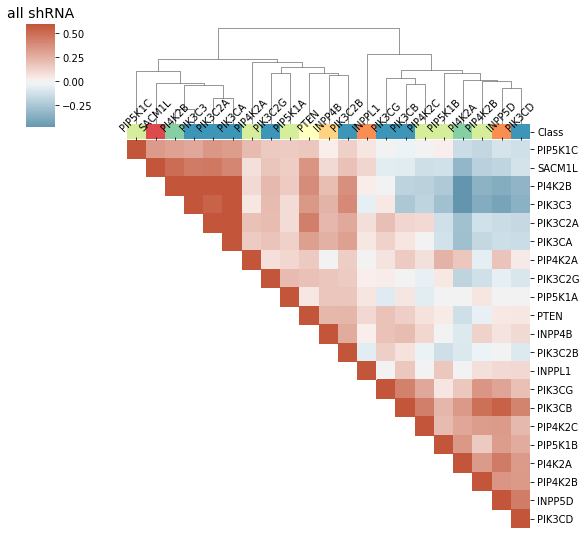

In [103]:
plot_clustermap(similarities_all, title = 'all shRNA', colors_dict = class_colors_to_df, figsize = (8,8))

### Some PCAs

In [113]:
print('Shape: ', signatures_lm.shape)
signatures_lm.iloc[:3, :10]

Shape:  (978, 4345)


,HDAC2,NDUFA1,MAST4,TIMM22,EXOSC10,IL2,P4HTM,PPIH,ZRSR2,MMEL1
gene_id,,,,,,,,,,
AARS,0.448108,-1.171052,0.623247,-0.047720,0.547921,0.097012,-0.850505,0.034572,-0.030693,0.466423
ABCF1,-0.072985,0.124655,-0.770469,-0.539039,0.417678,0.043322,-0.038163,-0.097319,-0.269221,0.232946
ABL1,-0.007028,-0.596339,0.246199,-0.522342,-0.438989,0.357414,-0.085730,0.633166,-0.155594,0.459184


In [114]:
def fit_model_pca(signatures):
    pca = PCA(4)
    principalComponents = pca.fit_transform(signatures)
    pcdf=pd.DataFrame(principalComponents,index=signatures.index,columns=['PC1','PC2','PC3', 'PC4'])
    print('Explained variance ratio: ', pca.explained_variance_ratio_)
    return pcdf

In [124]:
def plot_scatter_with_genes(pcdf, pcs = ('PC1', 'PC2'), genes = [], figsize = (10,10), above_thd = False, thds = (0,0)):
    
    hue_genes = pd.Series(0, index = pcdf.index)
    hue_genes.loc[genes] = 1
    
    fig, ax = plt.subplots(1, figsize = figsize)
    sns.scatterplot(pcdf[pcs[0]], pcdf[pcs[1]], color = 'lightgrey')
    sns.scatterplot(pcdf.loc[genes, pcs[0]], pcdf.loc[genes, pcs[1]], color = 'orange')
    for gene in genes:
        plt.text(x = pcdf.loc[gene, pcs[0]], y = pcdf.loc[gene, pcs[1]], s= gene, fontsize = 10, color = 'black')
    if above_thd:
        genes = pcdf[(pcdf[pcs[0]] > thds[0]) & (pcdf[pcs[1]] > thds[1])].index
        for gene in genes:
            plt.text(x = pcdf.loc[gene, pcs[0]], y = pcdf.loc[gene, pcs[1]], s= gene, fontsize = 8, color = 'black')
    

In [ ]:
# perturbation-wise

In [146]:
genes_selected_pert = select_genes_landmark(signatures_lm, kinases+phosphatases)

In [147]:
pcdf_pert = fit_model_pca(signatures_lm)

Explained variance ratio:  [0.24392491 0.09048427 0.02826758 0.01810174]


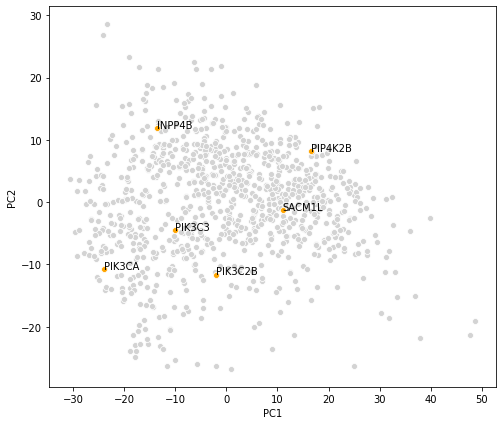

In [148]:
plot_scatter_with_genes(pcdf_pert, genes = genes_selected_pert, figsize = (8,7))

In [ ]:
# landmark-gene-wise

In [149]:
genes_selected = select_genes_perturbation(signatures_lm, kinases+phosphatases)

In [150]:
pcdf_lm = fit_model_pca(signatures_lm.T)

Explained variance ratio:  [0.22608542 0.03273789 0.0209542  0.0177756 ]


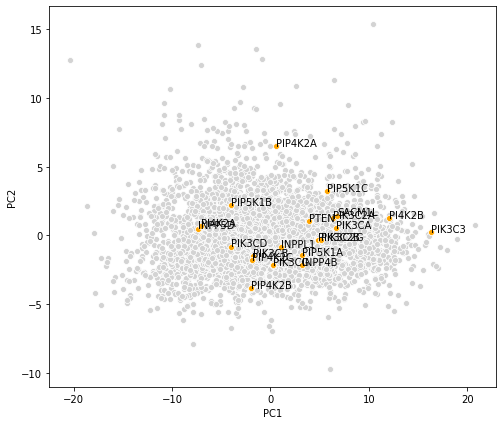

In [151]:
plot_scatter_with_genes(pcdf_lm, genes = genes_selected, figsize = (8,7))

### Remove PC1 from signatures

In [ ]:
# perturbation-wise

In [115]:
def remove_pc1(signatures, pcdf):
    columns = signatures.columns
    index = signatures.index
    signatures_removed_pc1 = {}
    i = 0
    for cols in columns:
        if i%100 == 0: print(i, end =',')
        X=pcdf['PC1']
        X=sm.add_constant(X)
        model = sm.OLS(signatures[cols],X)
        results=model.fit()
        signatures_removed_pc1[cols] = results.resid
        i = i+1
    signatures_removed_pc1 = pd.DataFrame.from_dict(signatures_removed_pc1)
    print('done')
    return signatures_removed_pc1

In [159]:
signatures_removed_pc1_pert = remove_pc1(signatures_lm, pcdf_pert)

0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400,3500,3600,3700,3800,3900,4000,4100,4200,4300,done


In [197]:
# write signatures removed pc1 to file
# signatures_removed_pc1_pert.to_csv(DATA_DIR+'signatures_lm_sh_pert_pc1removed.csv')

In [184]:
genes_selected_pert = select_genes_perturbation(signatures_removed_pc1_pert, kinases+phosphatases)
similarities_all_pert = calculate_similarity(signatures_removed_pc1_pert, genes_selected_pert)

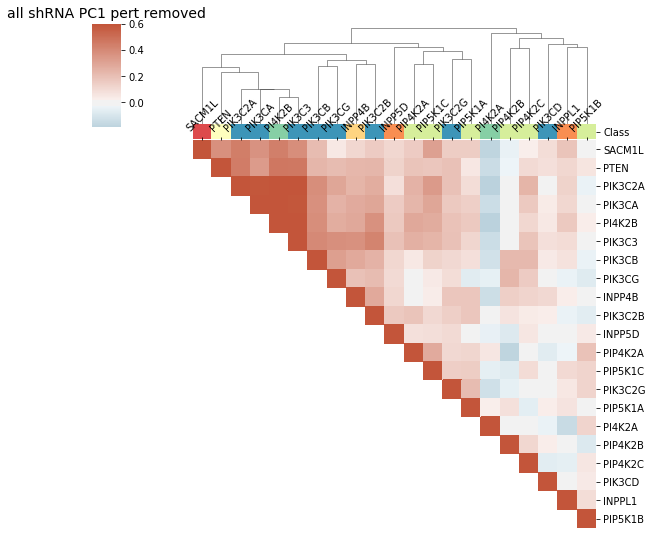

In [185]:
plot_clustermap(similarities_all_pert, title = 'all shRNA PC1 pert removed', 
                colors_dict = class_colors_to_df, figsize = (8,8))

In [186]:
# landmark-gene-wise

In [187]:
signatures_removed_pc1_lm = remove_pc1(signatures_lm.T, pcdf_lm)
signatures_removed_pc1_lm = signatures_removed_pc1_lm.T

0,100,200,300,400,500,600,700,800,900,done


In [198]:
# write signatures removed pc1 to file
# signatures_removed_pc1_lm.to_csv(DATA_DIR+'signatures_lm_sh_landmark_pc1removed.csv')

In [188]:
similarities_all_lm = calculate_similarity(signatures_removed_pc1_lm, genes_selected_pert)

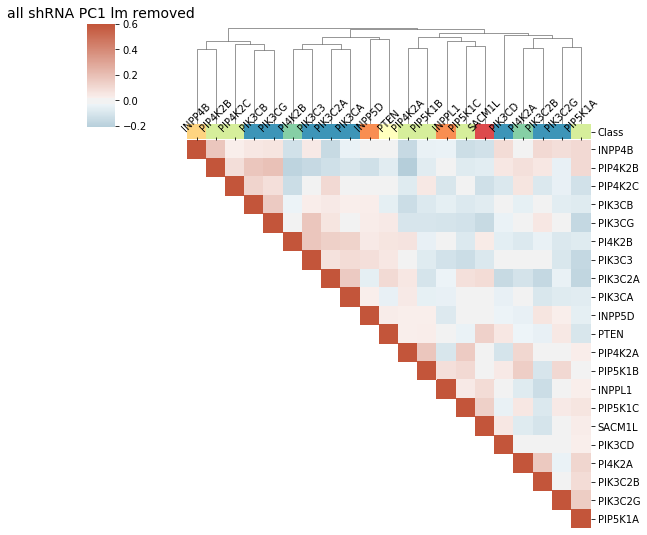

In [191]:
plot_clustermap(similarities_all_lm, title = 'all shRNA PC1 lm removed', 
                colors_dict = class_colors_to_df, figsize = (8,8))

# Quality control - are the expression of silenced genes low? 

In [193]:
def plot_histogram_expression(signatures, title, genes_selected = []):
    genes = np.intersect1d(signatures.index, signatures.columns)
    genes_expression = signatures.loc[genes, genes]
    genes_expression = pd.Series(np.diag(genes_expression), index=genes_expression.index)
    plt.hist(genes_expression, bins = 20)
    plt.title(title)
    if len(genes_selected) > 0:
        genes_selected = np.intersect1d(genes_selected, genes_expression.index)
        print(genes_expression.loc[genes_selected])

gene_id
INPP4B    -1.677112
PIK3C2B   -2.037435
PIK3C3    -1.613899
PIK3CA    -0.795441
PIP4K2B   -2.301265
SACM1L    -3.916888
dtype: float64


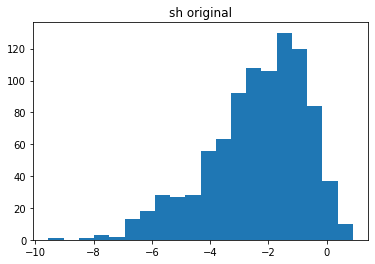

In [196]:
plot_histogram_expression(signatures_lm, 'sh original', genes_selected = kinases+phosphatases)

gene_id
INPP4B    -1.670857
PIK3C2B   -2.020945
PIK3C3    -1.371933
PIK3CA    -0.668934
PIP4K2B   -2.115376
SACM1L    -3.981551
dtype: float64


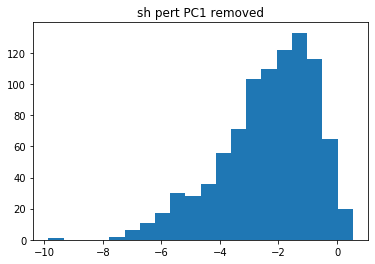

In [194]:
plot_histogram_expression(signatures_removed_pc1_pert, 'sh pert PC1 removed', genes_selected = kinases+phosphatases)

INPP4B    -1.884881
PIK3C2B   -1.797128
PIK3C3    -1.220556
PIK3CA    -0.441879
PIP4K2B   -2.166206
SACM1L    -3.947223
dtype: float64


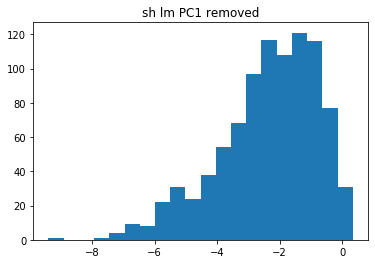

In [195]:
plot_histogram_expression(signatures_removed_pc1_lm, 'sh lm PC1 removed', genes_selected = kinases+phosphatases)

### TF analysis heatmaps and clustermaps - qulaity check

In [355]:
# np.intersect1d(metadata[metadata['Function'] == 'phosphatase'].index, dorothea_original.index)

array(['INPP4B', 'INPP5D', 'INPPL1', 'PTEN', 'SACM1L'], dtype=object)

In [465]:
# Quality control genes
qa_tfs = ['FOXO3', 'HIF1A', 'NFKB1', 'ATF4', 'RELA', 'NFKB2', 'CREB1', 'TP53', 'MYC']
pi3ks_and_pten = ['PIK3CA', 'PIK3C2B', 'PIK3C2G', 'PIK3C3', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'PTEN']
pi3ks = ['PIK3CA', 'PIK3C2B', 'PIK3C2G', 'PIK3C3', 'PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG']
ps = ['INPP4B', 'INPP5D', 'INPPL1', 'PTEN', 'SACM1L']
genes_selected = select_genes_perturbation(dorothea_original.T, metadata.index)

In [346]:
def plot_tf_clustermap(dorotea_signatures, perturbations, tfs):
    g = sns.clustermap(dorotea_signatures.loc[perturbations, tfs],
                   cmap = 'RdBu_r', figsize = (8, 6), center = 0)
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
    plt.show()

In [289]:
def plot_tf_heatmap(dorotea_signatures, perturbations, tfs):
    g = sns.heatmap(dorotea_signatures.loc[pi3ks_and_pten, tfs],
               cmap = 'RdBu_r', center = 0)
    plt.show()

In [339]:
def plot_heatmap_tfs_top_bottom(dorothea_signatures, perturbations, no = 15):
    fig, ax = plt.subplots(figsize=(10,5)) 
    top = dorothea_signatures.loc[perturbations].mean().sort_values().head(no).index
    bottom = dorothea_signatures.loc[perturbations].mean().sort_values().tail(no).index
    topbottomtfs = [*top, *bottom]
    g = sns.heatmap(dorothea_signatures.loc[perturbations, topbottomtfs],
               cmap = 'RdBu_r', center = 0)
    plt.show()

#### original

In [203]:
dorothea_original =  pd.read_csv(DATA_DIR+'dorothea_ABC_signatures_lm_sh.csv',
                                              index_col =0)

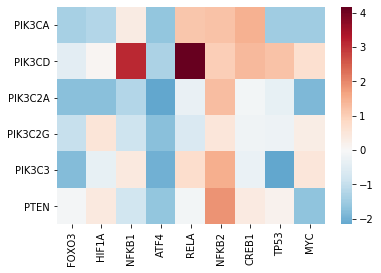

In [218]:
plot_tf_heatmap(dorothea_original, pi3ks_and_pten, qa_tfs)

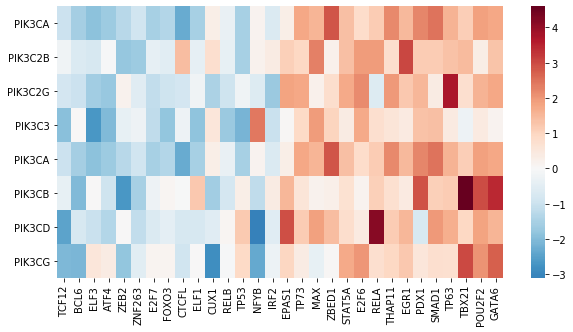

In [370]:
plot_heatmap_tfs_top_bottom(dorothea_original, pi3ks, no=15)

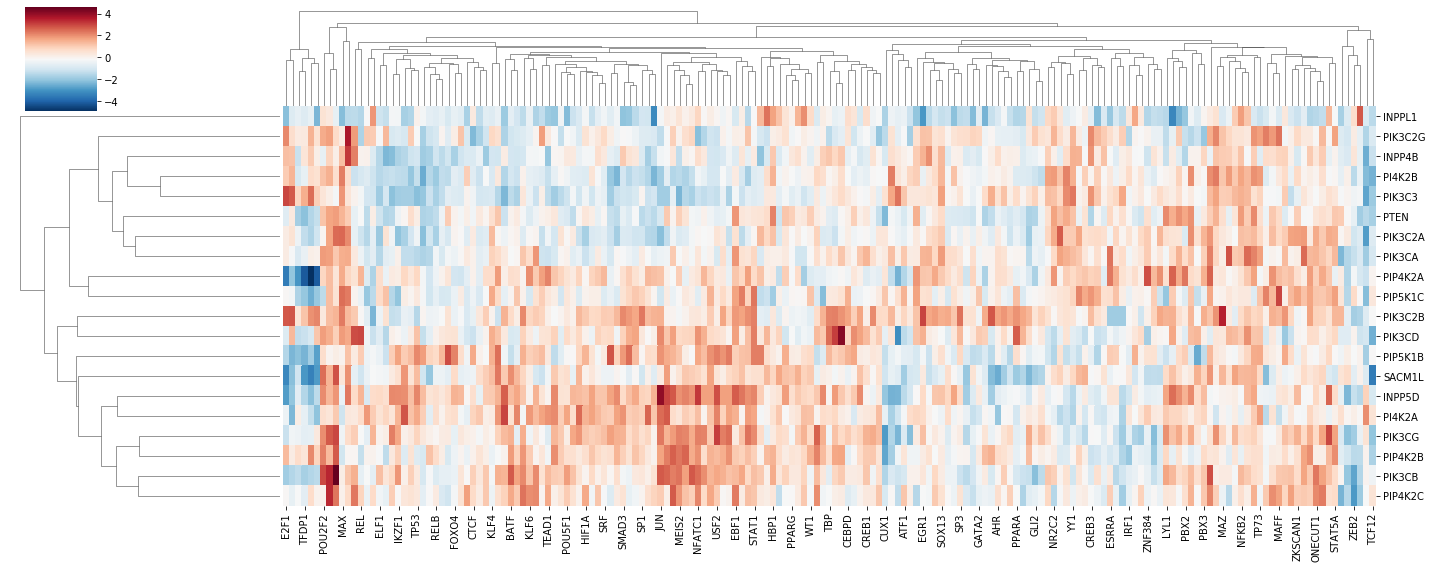

In [397]:
# All TFs and perturbed genes (shRNA)
sns.clustermap(dorothea_original.loc[genes_selected,:], cmap = 'RdBu_r', figsize = (20, 8))

#### perturbation-wise PC1 removal

In [205]:
dorothea_pert_removed_pc1 = pd.read_csv(DATA_DIR+'dorothea_ABC_signatures_lm_sh_pert_pc1removed.csv',
                                              index_col =0)

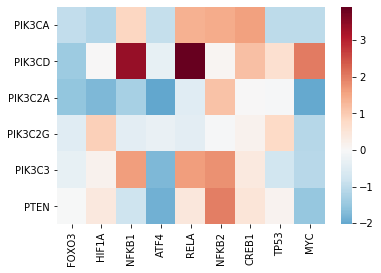

In [219]:
plot_tf_heatmap(dorothea_pert_removed_pc1, pi3ks_and_pten, qa_tfs)

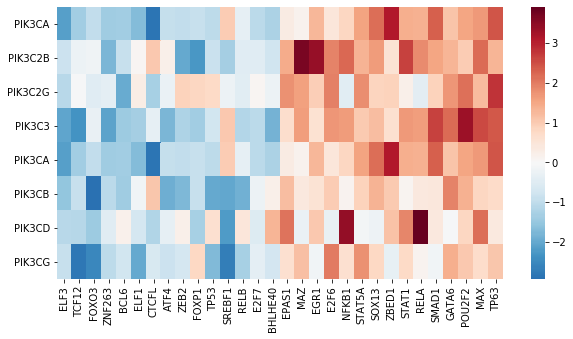

In [371]:
plot_heatmap_tfs_top_bottom(dorothea_pert_removed_pc1, pi3ks, no=15)

#### landmark gene-wise PC1 removal

In [207]:
dorothea_lm_removed_pc1 = pd.read_csv(DATA_DIR+'dorothea_ABC_signatures_lm_sh_landmark_pc1removed.csv',
                                              index_col =0)

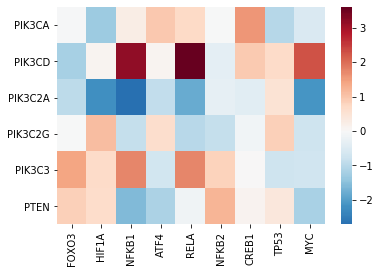

In [220]:
plot_tf_heatmap(dorothea_lm_removed_pc1, pi3ks_and_pten, qa_tfs)

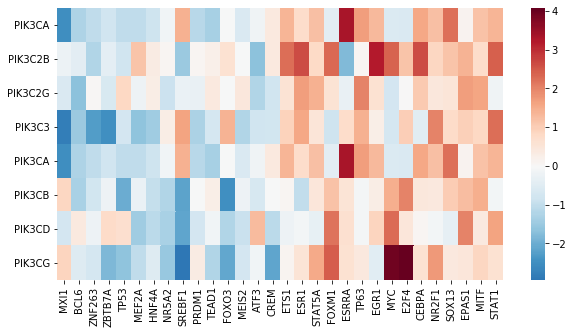

In [372]:
plot_heatmap_tfs_top_bottom(dorothea_lm_removed_pc1, pi3ks, no=15)

# Set perturbed expression value to 0

### Save signatures

##### original

In [444]:
treatment_type = 'trt_sh.cgs'
signatures_lm = pd.read_csv(DATA_DIR+'signatures_lm_'+treatment_type.split('_')[1]+'_genenames.csv', index_col = 0)
signatures_lm_perturbedgene_0 = signatures_lm.copy()

In [445]:
common_genes_pert_and_lm = np.intersect1d(signatures_lm_perturbedgene_0.index, selected_genes) # only lipid converting enzymes

In [446]:
signatures_lm_perturbedgene_0.loc[common_genes_pert_and_lm, common_genes_pert_and_lm] = 0

In [447]:
signatures_lm_perturbedgene_0 = signatures_lm_perturbedgene_0.loc[:, selected_genes]
signatures_lm_perturbedgene_0.to_csv(DATA_DIR+'signatures_lm_perturbedgene_0.csv')

##### PC1 removed pert

In [448]:
signatures_removed_pc1_pert_perturbedgene_0 = signatures_removed_pc1_pert.copy()
signatures_removed_pc1_pert_perturbedgene_0.loc[common_genes_pert_and_lm, common_genes_pert_and_lm] = 0
signatures_removed_pc1_pert_perturbedgene_0 = signatures_removed_pc1_pert_perturbedgene_0.loc[:, selected_genes]
signatures_lm_perturbedgene_0.to_csv(DATA_DIR+'signatures_lm_pc1removed_pert_perturbedgene_0.csv')

##### PC1 removed lm

In [449]:
signatures_removed_pc1_lm_perturbedgene_0 = signatures_removed_pc1_lm.copy()
signatures_removed_pc1_lm_perturbedgene_0.loc[common_genes_pert_and_lm, common_genes_pert_and_lm] = 0
signatures_removed_pc1_lm_perturbedgene_0 = signatures_removed_pc1_lm_perturbedgene_0.loc[:, selected_genes]
signatures_removed_pc1_lm_perturbedgene_0.to_csv(DATA_DIR+'signatures_lm_pc1removed_landmark_perturbedgene_0.csv')

### TF activity quality check -> FOXO3

In [469]:
signatures_perturbedgene_0_dorothea = pd.read_csv(DATA_DIR+'dorothea_ABC_signatures_lm_perturbedgene_0.csv', index_col =0)

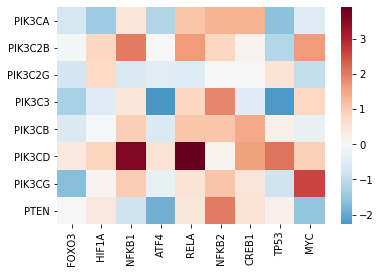

In [470]:
plot_tf_heatmap(signatures_perturbedgene_0_dorothea, pi3ks_and_pten, qa_tfs)

In [471]:
signatures_pc1removed_pert_perturbedgene_0_dorothea = pd.read_csv(DATA_DIR+'dorothea_ABC_signatures_lm_pc1removed_pert_perturbedgene_0.csv', 
                                                  index_col =0)

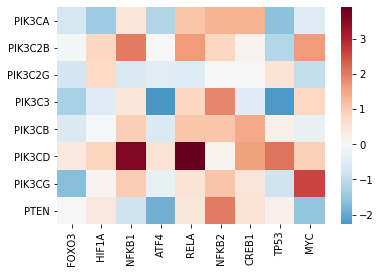

In [472]:
plot_tf_heatmap(signatures_pc1removed_pert_perturbedgene_0_dorothea, pi3ks_and_pten, qa_tfs)

In [473]:
signatures_pc1removed_lm_perturbedgene_0_dorothea = pd.read_csv(DATA_DIR+'dorothea_ABC_signatures_lm_pc1removed_landmark_perturbedgene_0.csv', 
                                                  index_col =0)

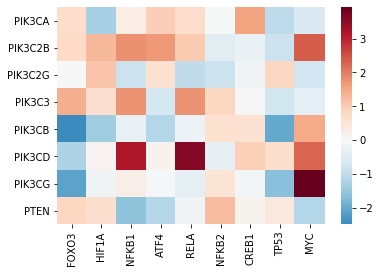

In [474]:
plot_tf_heatmap(signatures_pc1removed_lm_perturbedgene_0_dorothea, pi3ks_and_pten, qa_tfs)

# Cell signatures

In [ ]:
# Cells with >3000 perturbations (shRNAs)

In [478]:
metadata.index

Index(['PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'PIK3C2A', 'PIK3C2B', 'PIK3C2G',
       'PIK3C3', 'PI4K2A', 'PI4K2B', 'PIK4CA', 'PIK4CB', 'PIP5K1A', 'PIP5K1B',
       'PIP5K1C', 'PIP4K2A', 'PIP4K2B', 'PIP4K2C', 'PIP5K3', 'PTEN', 'TPTE2',
       'MTM1', 'MTMR1', 'MTMR2', 'MTMR3', 'MTMR4', 'MTMR6', 'MTMR7', 'MTMR8',
       'MTMR14', 'INPP4A', 'INPP4B', 'TMEM55A', 'TMEM55B', 'SYNJ1', 'SYNJ2',
       'OCRL', 'INPP5B', 'INPP5J', 'SKIP', 'INPP5D', 'INPPL1', 'INPP5E',
       'PTPMT1', 'SACM1L', 'INPP5F', 'FIG4'],
      dtype='object', name='GeneSymbol')

In [14]:
cell_signatures_filenames = glob.glob(DATA_DIR+'cell_signatures/signatures_lm_sh_*.csv')

In [30]:
cell_signatures = {}
for filename in cell_signatures_filenames:
    cell = filename.split('_')[-1].split('.')[0]
    cell_signatures[cell] = pd.read_csv(filename, index_col = 0)
    cell_signatures[cell] = map_gene_names(cell_signatures[cell])

In [41]:
cells_3000_pert = []
for i in cell_signatures:
    if cell_signatures[i].shape[1] > 3000:
        print(i, end = ', ')
        cells_3000_pert.append(i)

HA1E, A549, A375, HEPG2, MCF7, HT29, PC3, 

In [46]:
cell_signatures_3000_pert = { cell: cell_signatures[cell] for cell in cells_3000_pert }

In [502]:
cell_signatures_3000_pert.keys()

dict_keys(['HA1E', 'A549', 'A375', 'HEPG2', 'MCF7', 'HT29', 'PC3'])

In [499]:
def create_all_cell_signatures_dataframe(cell_signatures:dict):
    # phoshpatases and kinases
    pandks = metadata.index
    # data - first
    data = cell_signatures.copy()
    cells = list(data.keys())
    common_lmgenes = np.intersect1d(data[cells[0]].columns, pandks)
    data[cells[0]] = data[cells[0]][common_lmgenes]
    data[cells[0]] = data[cells[0]].add_suffix('_'+cells[0]) 
    signatures_all = data[cells[0]]
    # merge all other
    for i in range(1, len(cells)):
        common_lmgenes = np.intersect1d(data[cells[i]].columns, pandks)
        data[cells[i]] = data[cells[i]][common_lmgenes]
        data[cells[i]] = data[cells[i]].add_suffix('_'+cells[i])
        signatures_all = pd.merge(signatures_all, data[cells[i]], left_index = True, right_index = True)
    del data
    return signatures_all

In [500]:
cell_signatures_merged = create_all_cell_signatures_dataframe(cell_signatures_3000_pert)

In [507]:
# cell_signatures_merged.to_csv(DATA_DIR+'signatures_cells_lm_sh.csv')

### TF activities

In [508]:
tf_cells = pd.read_csv(DATA_DIR+'dorothea_ABC_ssignatures_cells_lm_sh.csv', index_col = 0)

In [525]:
cl, gs = zip(*tf_cells.index.str.split('_', expand = True))
colors = pd.Series(gs, cl).reset_index()
colors.columns = ['gene', 'cell']
colors.index = colors['gene'] + '_' + colors['cell']
# add cell color
colors_dict = dict(zip(colors['cell'].unique(),
                      list(reversed(sns.color_palette("YlGnBu", len(colors['cell'].unique())).as_hex()))))
colors['cell color'] = colors['cell'].map(colors_dict)

# add gene color
colors_dict = dict(zip(colors['gene'].unique(),
                      list(reversed(sns.color_palette("coolwarm", len(colors['gene'].unique())).as_hex()))))
colors['gene color'] = colors['gene'].map(colors_dict)

# add kinase/phosphatase color
colors['kinase/phosphatase'] =  np.where(colors['gene'].isin(kinases), 'darkblue', 'white')
    

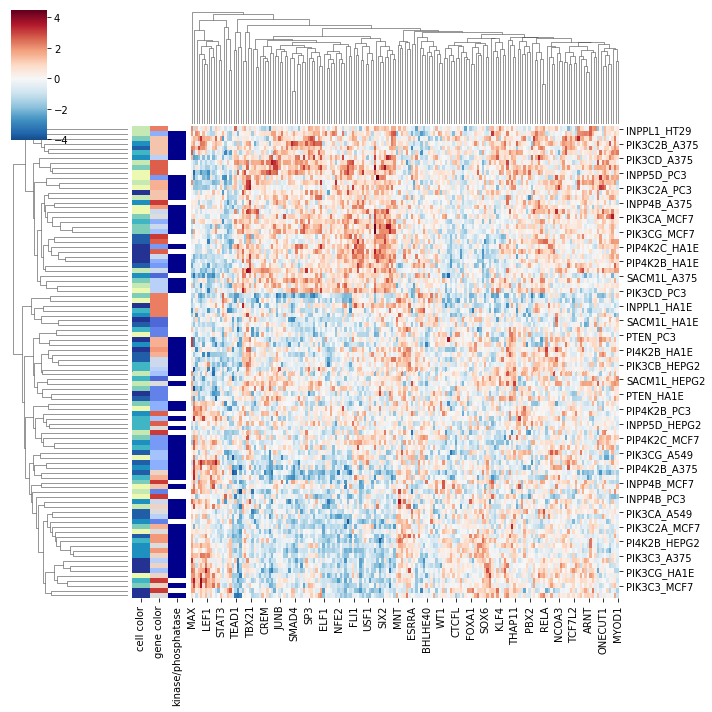

In [527]:
sns.clustermap(tf_cells, center = 0, cmap = 'RdBu_r', 
               row_colors = colors[['cell color', 'gene color', 'kinase/phosphatase']])

In [529]:
# calculate similarities
common_genes = cell_signatures_merged.columns
similarities_all = pd.DataFrame(index = common_genes, columns = common_genes)
for gene in common_genes:
    for pert in common_genes:
        similarities_all.loc[gene, pert] = spearmanr(cell_signatures_merged[gene], cell_signatures_merged[pert])[0]
similarities_all = similarities_all.astype('float')

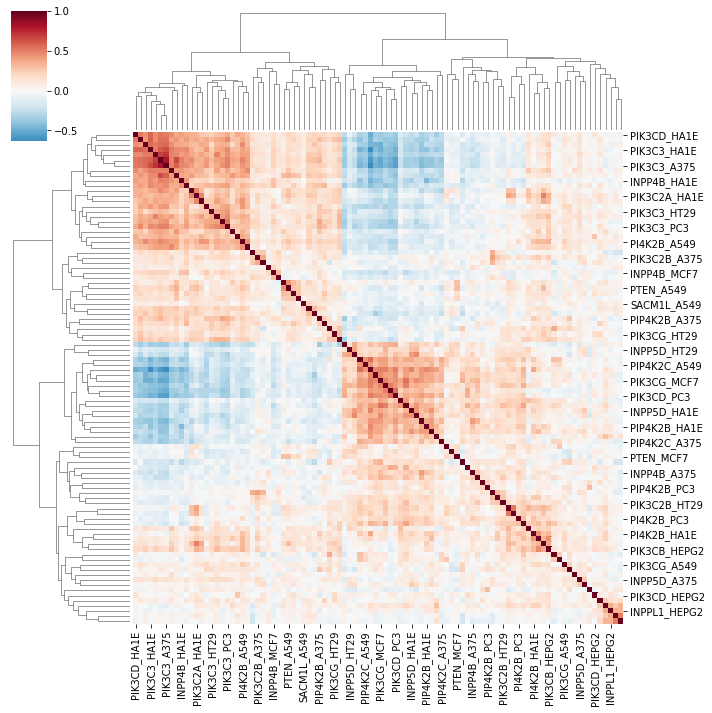

In [534]:
sns.clustermap(similarities_all, cmap = 'RdBu_r', center = 0)

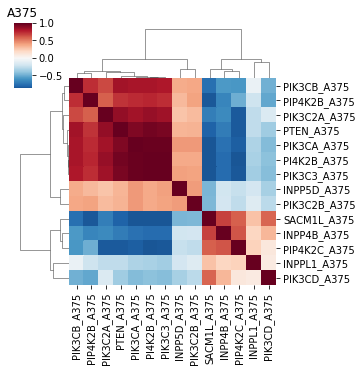

In [567]:
gene = 'A375'
sns.clustermap(similarities_all[[s for s in similarities_all.columns if gene in s]].corr(), cmap = 'RdBu_r', 
               figsize = (5,5), center = 0)
plt.title(gene)
plt.show()

# Linear model

In [ ]:
# KD pert x landmark genes
# perturbation model matrix
# coeffitients? -> new matrix

In [575]:
signatures_lm = pd.read_csv(DATA_DIR+'signatures_lm_'+treatment_type.split('_')[1]+'_genenames.csv', index_col = 0)

In [579]:
lce_df = signatures_lm[np.intersect1d(signatures_lm.columns, metadata.index)]

In [580]:
lce_df

,INPP4B,INPP5D,INPPL1,PI4K2A,PI4K2B,PIK3C2A,PIK3C2B,PIK3C2G,PIK3C3,PIK3CA,...,PIK3CD,PIK3CG,PIP4K2A,PIP4K2B,PIP4K2C,PIP5K1A,PIP5K1B,PIP5K1C,PTEN,SACM1L
gene_id,,,,,,,,,,,,,,,,,,,,,
AARS,-0.285316,0.761347,-0.068827,-0.176711,0.140835,-0.080555,-0.011979,-0.162087,0.405698,-0.446135,...,-0.394926,0.011688,0.592567,-0.157898,-0.168958,-0.130933,-0.038747,0.558512,-0.218600,0.319372
ABCF1,-0.085210,-0.253798,-0.379759,0.246171,-0.433032,-0.081001,-0.575998,-0.338464,-0.408759,-0.103441,...,0.166754,0.058346,0.005151,0.144399,0.375344,-0.355354,-1.431066,0.329636,0.352941,-0.134187
ABL1,-0.329675,0.285485,-0.651771,0.132711,0.247295,0.288372,0.320982,-2.302623,0.479374,0.280940,...,-0.352662,0.187693,0.110186,0.052885,-0.368104,-0.285074,-0.865059,-1.478145,0.219110,-0.438195
ACAA1,0.069316,0.419135,0.535609,-0.050397,0.615301,0.337734,0.143996,-0.247671,0.080555,0.174421,...,0.215420,-0.053734,0.224470,0.176929,0.154908,0.347658,-0.346929,1.148609,0.321601,0.944484
ACAT2,0.210328,-0.092870,0.028889,-0.852221,-0.502265,-0.171398,-0.363504,-0.080011,-0.643254,-0.320539,...,-0.552107,-0.155784,-0.378056,-0.172832,0.147204,0.494783,0.236170,0.267284,-0.210693,0.284722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TXLNA,0.223900,-0.338814,-0.721350,-1.131413,0.474841,0.176872,-0.163105,-0.507706,0.332804,0.120230,...,0.091143,-0.278794,-0.740912,-0.255407,-0.880149,0.328784,-0.106232,-0.437039,0.077858,0.591056
SPRED2,-0.409907,0.260248,-0.736106,0.451515,-0.652426,-0.539037,-0.240376,-0.589119,-0.992283,-0.691839,...,-0.243220,-0.761461,-0.481061,0.088886,-0.157545,-0.002937,-0.384963,-0.549620,-0.335702,-0.587761
EML3,0.326560,0.169585,0.136394,0.036974,0.138259,0.202584,0.315964,-0.041744,0.148516,0.290514,...,-0.229040,0.461323,0.826638,0.374263,0.696979,0.087872,0.096543,0.138225,0.515844,0.367919
